## LLM System Message Optimize

We create a function that calls an LLM API -- the system message is wrapped as a parameter node.

Then we use `trace` to analyze this.

In [1]:
import autogen
from opto.trace import bundle, node
from opto.optimizers import FunctionOptimizer
from opto.trace.nodes import GRAPH

In [4]:
from datasets import load_dataset
from autogen.math_utils import is_equiv

In [3]:
dataset = load_dataset("hendrycks/competition_math")

/piech/u/anie/miniconda3/envs/verbal-gym/lib/python3.8/site-packages/datasets/load.py:1461: FutureWarning: The repository for hendrycks/competition_math contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hendrycks/competition_math
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [17]:
def remove_boxed(string: str):
    """Source: https://github.com/hendrycks/math
    Extract the text within a \\boxed{...} environment.
    Example:

    > remove_boxed("\\boxed{\\frac{2}{3}}")

    \\frac{2}{3}
    """
    left = "\\boxed{"
    if left not in string:
        left = "\boxed{"
    try:
        if not all((string[: len(left)] == left, string[-1] == "}")):
            raise AssertionError

        return string[len(left) : -1]
    except Exception:
        return None


def last_boxed_only_string(string: str):
    """Source: https://github.com/hendrycks/math
    Extract the last \\boxed{...} or \\fbox{...} element from a string.
    """
    idx = string.rfind("\\boxed")
    if idx < 0:
        idx = string.rfind("\\fbox")
        if idx < 0:
            idx = string.rfind("\boxed")
            if idx < 0:
                return None

    i = idx
    right_brace_idx = None
    num_left_braces_open = 0
    while i < len(string):
        if string[i] == "{":
            num_left_braces_open += 1
        if string[i] == "}":
            num_left_braces_open -= 1
            if num_left_braces_open == 0:
                right_brace_idx = i
                break
        i += 1

    if right_brace_idx is None:
        retval = None
    else:
        retval = string[idx : right_brace_idx + 1]

    return retval


def get_answer(solution):
    if solution is None:
        return None
    last_boxed = last_boxed_only_string(solution)
    if last_boxed is None:
        return None
    answer = remove_boxed(last_boxed)
    if answer is None:
        return None
    return answer


def check_equiv(sol1, sol2):
    return is_equiv(get_answer(sol1), get_answer(sol2))

In [27]:
llm = autogen.OpenAIWrapper(config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))


def call_llm(prompt, verbose=False):
    """Call the LLM with a prompt and return the response."""
    if verbose:
        print("Prompt\n", prompt)

    try:
        response = llm.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            response_format={"type": "json_object"},
        )
    except Exception:
        response = llm.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
        )
    response = response.choices[0].message.content

    if verbose:
        print("LLM response:\n", response)
    return response


def wrap_q_in_text(q, instruction):
    text = f"Q:{instruction}\n{q}\n\nA:"
    return text


@bundle()
def generate_answer(system_message, q):
    q_rep = wrap_q_in_text(q, system_message)
    answer = call_llm(q_rep, verbose=True)
    return answer


def get_feedback(a_hat, a):
    score = check_equiv(a_hat, a)
    if score == 0:
        feedback = "The solution is not correct."
    else:
        feedback = "Success."
    return feedback

In [28]:
system_message = "Let’s work this out in a step by step way to be sure we have the right answer."
system_message = node(system_message, "system_prompt", trainable=True)

answer = generate_answer(system_message, dataset["train"][0]["problem"])

Prompt
 Q:Let’s work this out in a step by step way to be sure we have the right answer.
Let \[f(x) = \left\{
\begin{array}{cl} ax+3, &\text{ if }x>2, \\
x-5 &\text{ if } -2 \le x \le 2, \\
2x-b &\text{ if } x <-2.
\end{array}
\right.\]Find $a+b$ if the piecewise function is continuous (which means that its graph can be drawn without lifting your pencil from the paper).

A:
LLM response:
 For a piecewise function to be continuous, the "pieces" must match up at the places where they change; that is, the y-values must be the same at the x-values where the pieces switch over.

Here we can see that the pieces switch at x = 2 and x = -2. We therefore need to ensure that the y-values of the different pieces match up at these x-values. 

At x = 2, we have:

    f(2) = 2 - 5       (from the second piece)
    f(2) = 2a + 3   (from the first piece)

Setting these equal to each other, we get:

    2 - 5 = 2a + 3
    -3 = 2a + 3
    -6 = 2a
    a = -3

At x = -2, we have:

    f(-2) = -2 - 5      

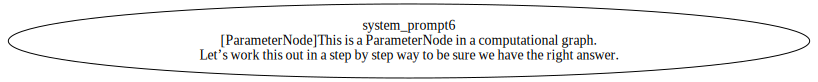

In [29]:
system_message.backward(visualize=True)